In [1]:
import numpy as np
import pandas as pd

#widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

#plots
import matplotlib.pyplot as plt
from plotnine import *

#stats
import scipy as sp
import statsmodels as sm

#silence warnings on kaggle
import warnings
warnings.filterwarnings("ignore")

In [2]:
def gen_campaigns(p1,p2,nb_days,scaler,seed):
    #generate fake data
    np.random.seed(seed)
    ns = np.random.triangular(500,1000,1500,size=120).astype(int)
    np.random.seed(seed)
    es = np.random.randn(nb_days*2) / scaler

    n1 = ns[:nb_days]
    c1 = ((p1 + es[:nb_days]) * n1).astype(int)
    n2 = ns[nb_days:]
    c2 = ((p2 + es[nb_days:]) * n2).astype(int)
    conv_days = pd.DataFrame({'click_day':range(nb_days),'click_a':n1,'conv_a':c1,'click_b':n2,'conv_b':c2})

    conv_days =  conv_days[['click_day','click_a','click_b','conv_a','conv_b']]
    conv_days['cumu_click_a'] = conv_days.click_a.cumsum()
    conv_days['cumu_click_b'] = conv_days.click_b.cumsum()
    conv_days['cumu_conv_a'] = conv_days.conv_a.cumsum()
    conv_days['cumu_conv_b'] = conv_days.conv_b.cumsum()
    conv_days['cumu_rate_a'] = conv_days.cumu_conv_a / conv_days.cumu_click_a
    conv_days['cumu_rate_b'] = conv_days.cumu_conv_b / conv_days.cumu_click_b
    return conv_days

conv_days = gen_campaigns(p1 = 0.10,
                          p2 = 0.105,
                          nb_days = 60,
                          scaler=300,
                          seed = 1412) #god-mode 
conv_days.head()

,click_day,click_a,click_b,conv_a,conv_b,cumu_click_a,cumu_click_b,cumu_conv_a,cumu_conv_b,cumu_rate_a,cumu_rate_b
0,0,1254,1007,126,105,1254,1007,126,105,0.100478,0.104270
1,1,1147,549,116,60,2401,1556,242,165,0.100791,0.106041
2,2,678,955,67,98,3079,2511,309,263,0.100357,0.104739
3,3,968,764,94,82,4047,3275,403,345,0.099580,0.105344
4,4,899,969,93,99,4946,4244,496,444,0.100283,0.104618


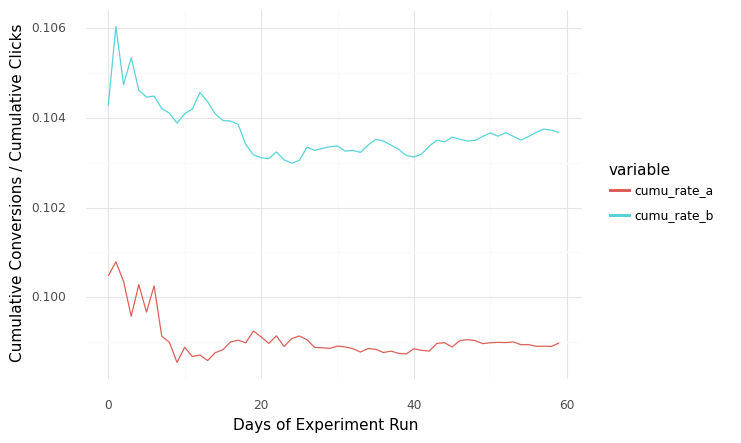

<ggplot: (157409720566)>

In [3]:
rates_df = conv_days[['click_day','cumu_rate_a','cumu_rate_b']].melt(id_vars='click_day')
g = (ggplot(rates_df, aes(x='click_day', y='value', color='variable')) + geom_line() + theme_minimal() +
          xlab('Days of Experiment Run') + ylab('Cumulative Conversions / Cumulative Clicks'))
g

In [4]:
#sum after 2 months
conv_df = pd.DataFrame({'campaign_id':['A','B'], 'clicks':[conv_days.click_a.sum(),conv_days.click_b.sum()],
                        'conv_cnt':[conv_days.conv_a.sum(),conv_days.conv_b.sum()]})
conv_df['conv_per'] =  conv_df['conv_cnt'] / conv_df['clicks']
conv_df

,campaign_id,clicks,conv_cnt,conv_per
0,A,59504,5890,0.098985
1,B,58944,6111,0.103675


In [5]:
def bernoulli(n,p):
    flips = np.random.choice([0,1], size=n, p=[1-p,p])
    flips_df = pd.DataFrame(flips)
    flips_df.columns = ['conv_flag']
    g = (ggplot(flips_df,aes(x='factor(conv_flag)')) + geom_bar(aes(y = '(..count..)/sum(..count..)'))  + 
        theme_minimal() + xlab('Conversion Flag') + ylab('Percentage of Occurence') +
        geom_hline(yintercept=p, colour='red') + ggtitle(f'Distribution after {n} Trials'))
    g.draw()
    print(f'Expectation: {p}\nVariance: {p*(1-p)}')
    print(f'Sample Mean: {np.mean(flips)}\nSample Variance: {np.var(flips)}')

interact(bernoulli, n=widgets.IntSlider(min=1,max=500,step=1,value=20),
        p=widgets.FloatSlider(min=0.1,max=0.9))

interactive(children=(IntSlider(value=20, description='n', max=500, min=1), FloatSlider(value=0.1, description…

<function __main__.bernoulli(n, p)>

In [6]:
def lln(n_max,p):
    mean_flips = []
    var_flips = []
    ns = []
    for n in range(1,n_max):
        flips = np.random.choice([0,1], size=n, p=[1-p,p])
        ns.append(n)
        mean_flips.append(flips.mean())
        var_flips.append(flips.var())
    flips_df = pd.DataFrame({'n':ns,'mean_flips':mean_flips,'var_flips':var_flips}).melt(id_vars='n')
    g = (ggplot(flips_df,aes(x='n',y='value',colour='variable')) + geom_line() +
        facet_wrap('~variable', ncol=1, scales='free') + theme_minimal() +
        ggtitle(f'Expectation={p:2f}; Variance={p*(1-p):2f}') + xlab('Number of Samples') +
        ylab('Value'))
    g.draw()

interact(lln, n_max=widgets.IntSlider(min=2,max=10000,step=1,value=1000),
        p=widgets.FloatSlider(min=0.1,max=0.9))

interactive(children=(IntSlider(value=1000, description='n_max', max=10000, min=2), FloatSlider(value=0.1, des…

<function __main__.lln(n_max, p)>

In [7]:
c_df = pd.DataFrame({'campaign_id':'C','clicks':1000,'conv_cnt':107,'conv_per':0.107},index=[0])
c_df

,campaign_id,clicks,conv_cnt,conv_per
0,C,1000,107,0.107


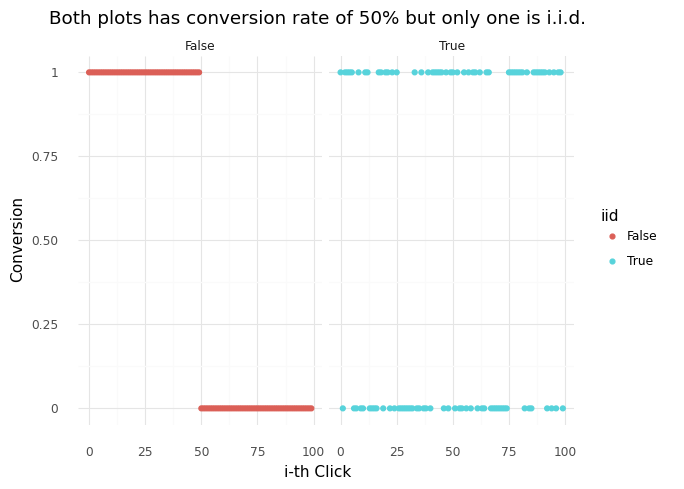

<ggplot: (157412142691)>

In [8]:
ind_df = pd.DataFrame({'iid':[False]*100+[True]*100,
                       'order': list(range(100)) + list(range(100)),
                       'conv_flag':[1]*50+ [0]*50+ list(np.random.choice([0,1], size=100))})
g = (ggplot(ind_df,aes(x='order',y='conv_flag',color='iid')) + geom_point() +
     facet_wrap('~iid') + theme_minimal() + xlab('i-th Click') + ylab('Conversion') +
     ggtitle('Both plots has conversion rate of 50% but only one is i.i.d.'))
g

In [9]:
def clt(n, dist):
    n_total = n * 10000
    if dist == 'discrete uniform':
        r = np.random.uniform(size=n_total)
    elif dist =='bernoulli':
        r = np.random.choice([0,1],size=n_total,p=[0.9,0.1])
    elif dist =='poisson':
        r = np.random.poisson(size=n_total)
    else:
        raise ValueError('Choose distributions that are available')
    #generate base distribution plot
    r_df = pd.DataFrame({'r':r})
    g1 = (ggplot(r_df, aes(x='r')) + geom_histogram(bins=30) + theme_minimal() +
         xlab('Values') + ylab('Number of Samples') + 
         ggtitle(f'{dist} distribution where sample groups are drawn from'))
    g1.draw()
    
    #generate sample mean distribution plot
    normal_distribution = np.random.normal(loc=np.mean(r), scale=np.std(r) / np.sqrt(n), size=10000)
    sm_df = pd.DataFrame({'sample_means':r.reshape(-1,n).mean(1),
                          'normal_distribution': normal_distribution}).melt()
    g2 = (ggplot(sm_df, aes(x='value',fill='variable')) + 
          geom_histogram(bins=30,position='nudge',alpha=0.5) + 
          theme_minimal() + xlab('Sample Means') + ylab('Number of Sample Means') + 
         ggtitle(f'Distribution of 10,000 sample means with size {n}')) 
    g2.draw()
    

dists = ['bernoulli','discrete uniform','poisson']
interact(clt, n=widgets.IntSlider(min=1,max=100,value=30),
         dist = widgets.Dropdown(
                options=dists,
                value='bernoulli')
)

interactive(children=(IntSlider(value=30, description='n', min=1), Dropdown(description='dist', options=('bern…

<function __main__.clt(n, dist)>

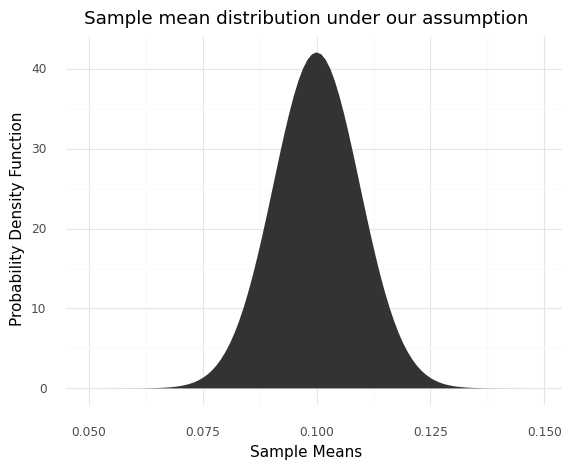

<ggplot: (157409679613)>

In [10]:
n = c_df.clicks[0]
x_bar = c_df.conv_per[0]
p = 0.1
mu = p; variance = p*(1-p)/n; sigma = (variance)**(0.5)
# mu = 0; variance = 1; sigma = (variance)**(0.5)
x = np.arange(0.05, 0.15, 1e-3)
y = np.array([sp.stats.norm.pdf(i, loc=mu, scale=sigma) for i in x])

sm_df = pd.DataFrame({'x': x, 'y': y, 'crit':[False if i>x_bar else True for i in x]})
g = (ggplot(sm_df, aes(x='x', y='y')) + geom_area() +
      theme_minimal() + xlab('Sample Means') + ylab('Probability Density Function') + 
      ggtitle('Sample mean distribution under our assumption')) 
g

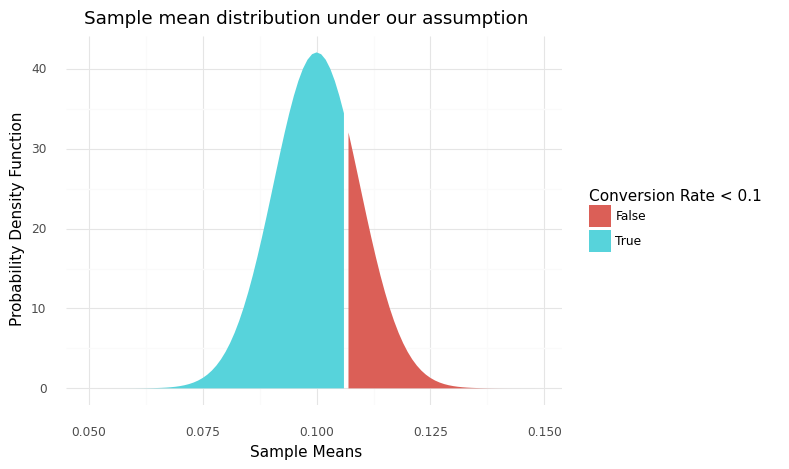

<ggplot: (157412183409)>

In [11]:
g = (ggplot(sm_df, aes(x='x', y='y', group='crit')) + geom_area(aes(fill='crit')) +
      theme_minimal() + xlab('Sample Means') + ylab('Probability Density Function') + 
      ggtitle('Sample mean distribution under our assumption') + 
      guides(fill=guide_legend(title="Conversion Rate < 0.1"))) 
g

In [12]:
def shift_normal(m,v):
    n = c_df.clicks[0]
    x_bar = c_df.conv_per[0]
    p = 0.1
    mu = p; variance = p*(1-p)/n; sigma = (variance)**(0.5)
    x = np.arange(0.05, 0.15, 1e-3)
    y = np.array([sp.stats.norm.pdf(i, loc=mu, scale=sigma) for i in x])
    sm_df = pd.DataFrame({'x': x, 'y': y})
    
    #normalize process
    sm_df['x'] = (sm_df.x - m) / np.sqrt(v)
    sm_df['y'] = np.array([sp.stats.norm.pdf(i, loc=mu-m, scale=sigma/np.sqrt(v)) for i in sm_df.x])
    print(f'Expectation of sample mean: {mu-m}; Variance of sample mean: {variance/v}')
    g = (ggplot(sm_df, aes(x='x', y='y')) + geom_area() +
          theme_minimal() + xlab('Sample Means') + ylab('Probability Density Function') + 
          ggtitle('Shifted Normal Distribution of Sample Mean')) 
    g.draw()
    
interact(shift_normal, 
         m=widgets.FloatSlider(min=-1e-1,max=1e-1,value=1e-1,step=1e-2),
         v=widgets.FloatSlider(min=9e-5,max=9e-3,value=9e-5,step=1e-4, readout_format='.5f'))

interactive(children=(FloatSlider(value=0.1, description='m', max=0.1, min=-0.1, step=0.01), FloatSlider(value…

<function __main__.shift_normal(m, v)>

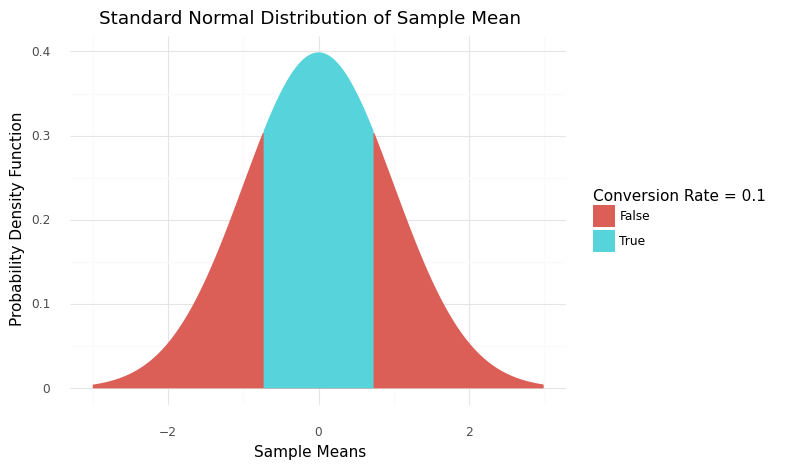

In [13]:
n = c_df.clicks[0]
x_bar = c_df.conv_per[0]
p = 0.1; mu = p; variance = p*(1-p)/n; sigma = (variance)**(0.5)
x_bar_norm = (x_bar - mu) / sigma

def standard_normal(x_bar_norm, legend_title):
    x_bar_norm = abs(x_bar_norm)
    x = np.arange(-3, 3, 1e-2)
    y = np.array([sp.stats.norm.pdf(i, loc=0, scale=1) for i in x])
    sm_df = pd.DataFrame({'x': x, 'y': y})

    #normalize process
    sm_df['crit'] = sm_df.x.map(lambda x: False if ((x<-x_bar_norm)|(x>x_bar_norm)) else True)
    g = (ggplot(sm_df, aes(x='x', y='y',group='crit')) + geom_area(aes(fill='crit')) +
          theme_minimal() + xlab('Sample Means') + ylab('Probability Density Function') + 
          ggtitle('Standard Normal Distribution of Sample Mean') +
          guides(fill=guide_legend(title=legend_title))) 
    g.draw()

standard_normal(x_bar_norm, "Conversion Rate = 0.1")

In [14]:
conv_df

,campaign_id,clicks,conv_cnt,conv_per
0,A,59504,5890,0.098985
1,B,58944,6111,0.103675


Z-value: -2.6744183909575856; p-value: 0.00748589934574917


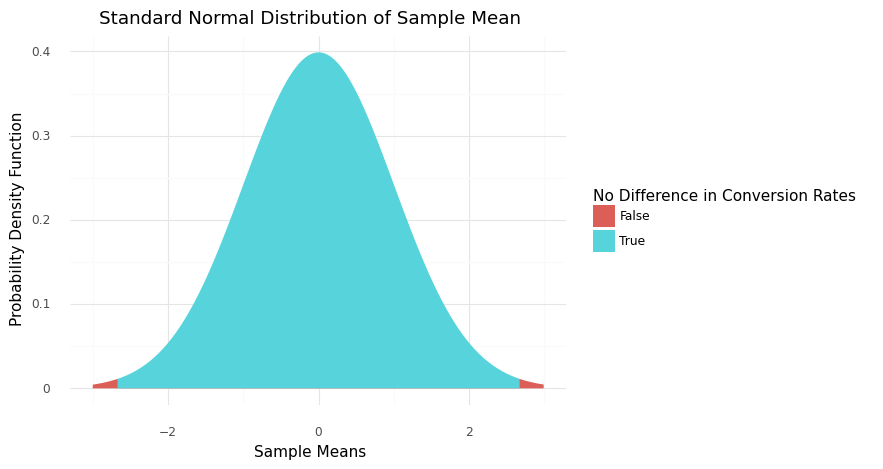

In [15]:
def proportion_test(c1, c2, n1, n2, mode = 'two_sided'):
    p = (c1+c2) / (n1+n2)
    p1 = c1 / n1
    p2 = c2 / n2
    z = (p1-p2) / np.sqrt(p*(1-p)*(1/n1 + 1/n2))
    if mode=='two_sided':
        p = 2*(1-sp.stats.norm.cdf(abs(z)))
    elif mode=='one_sided':
        p = 1-sp.stats.norm.cdf(abs(z))
    else:
        raise ValueError('Available modes are `one_sided` and `two_sided`')
    return z, p

z_value, p_value = proportion_test(c1=conv_df.conv_cnt[0], c2=conv_df.conv_cnt[1],
                n1=conv_df.clicks[0], n2=conv_df.clicks[1], mode='two_sided')
print(f'Z-value: {z_value}; p-value: {p_value}')

standard_normal(z_value, "No Difference in Conversion Rates")

In [16]:
def ci_plot(p1,p2,n1,n2,alpha=0.05):
    p = (p1*n1+p2*n2) / (n1+n2)
    se1 = np.sqrt(p1*(1-p1)/n1)
    se2 = np.sqrt(p2*(1-p2)/n2)
    z = sp.stats.norm.ppf(1-alpha/2)
    x1 = np.arange(p1-3*se1,p1+3*se1,1e-4)
    x2 = np.arange(p2-3*se2,p2+3*se2,1e-4)
    y1 = np.array([sp.stats.norm.pdf(i, loc=p1, scale=np.sqrt(p1*(1-p1)/n1)) for i in x1])
    y2 = np.array([sp.stats.norm.pdf(i, loc=p2, scale=np.sqrt(p2*(1-p2)/n2)) for i in x2])
    sm_df = pd.DataFrame({'campaign_id': ['Campaign A'] * len(x1) + ['Campaign B'] * len(x2),
        'x':np.concatenate([x1,x2]),'y':np.concatenate([y1,y2])})
    
    #test
    z_value, p_value = proportion_test(p1*n1, p2*n2, n1,n2, mode='two_sided')
    print(f'Z-value: {z_value}; p-value: {p_value}')
    
    g = (ggplot(sm_df, aes(x='x', y='y', fill='campaign_id')) + geom_area(alpha=0.5) +
      theme_minimal() + xlab('Sample Mean Distribution of Each Campaign') + 
      ylab('Probability Density Function') + 
      geom_vline(xintercept=[p1+se1*z,p1-se1*z], colour='red') +
      geom_vline(xintercept=[p2+se2*z,p2-se2*z], colour='blue') +
      ggtitle(f'Confident Intervals at alpha={alpha}')) 
    g.draw()
    
interact(ci_plot, 
         p1 = widgets.FloatSlider(min=0,max=1,value=conv_df.conv_cnt[0] / conv_df.clicks[0],
                                 step=1e-3,readout_format='.5f'),
         p2 = widgets.FloatSlider(min=0,max=1,value=conv_df.conv_cnt[1] / conv_df.clicks[1],
                                 step=1e-3,readout_format='.5f'),
         n1 = widgets.IntSlider(min=10,max=70000,value=conv_df.clicks[0]),
         n2 = widgets.IntSlider(min=10,max=70000,value=conv_df.clicks[1]),
         alpha = widgets.FloatSlider(min=0,max=1,value=0.05))

interactive(children=(FloatSlider(value=0.09898494218876042, description='p1', max=1.0, readout_format='.5f', …

<function __main__.ci_plot(p1, p2, n1, n2, alpha=0.05)>

In [17]:
def significance_plot(p1,p2):
    n1s = pd.DataFrame({'n1':[10**i for i in range(1,7)],'k':0})
    n2s = pd.DataFrame({'n2':[10**i for i in range(1,7)],'k':0})
    ns = pd.merge(n1s,n2s,how='outer').drop('k',1)
    ns['p_value'] = ns.apply(lambda row: proportion_test(p1*row['n1'], p2*row['n2'],row['n1'],row['n2'])[1], 1)
    g = (ggplot(ns,aes(x='factor(n1)',y='factor(n2)',fill='p_value')) + geom_tile(aes(width=.95, height=.95)) +
        geom_text(aes(label='round(p_value,3)'), size=10)+ theme_minimal() +
        xlab('Number of Samples in A') + ylab('Number of Samples in B') +
        guides(fill=guide_legend(title="p-value")))
    g.draw()

interact(significance_plot, 
         p1 = widgets.FloatSlider(min=0,max=1,value=conv_df.conv_cnt[0] / conv_df.clicks[0],
                                 step=1e-3,readout_format='.5f'),
         p2 = widgets.FloatSlider(min=0,max=1,value=conv_df.conv_cnt[1] / conv_df.clicks[1],
                                 step=1e-3,readout_format='.5f'))

interactive(children=(FloatSlider(value=0.09898494218876042, description='p1', max=1.0, readout_format='.5f', …

<function __main__.significance_plot(p1, p2)>

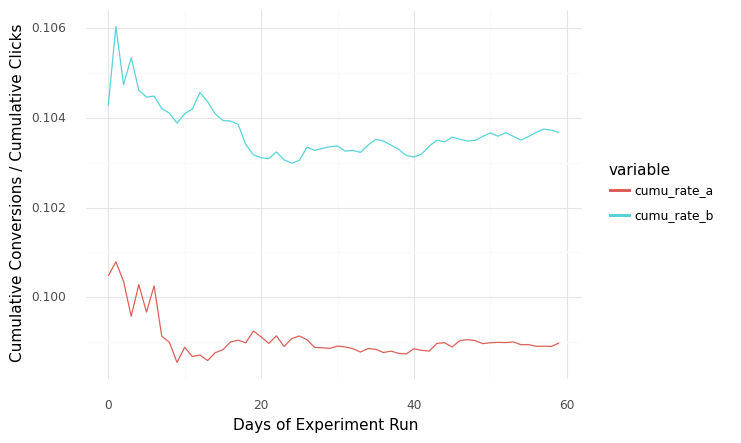

<ggplot: (-9223371879441080860)>

In [18]:
g = (ggplot(rates_df, aes(x='click_day', y='value', color='variable')) + geom_line() + theme_minimal() +
          xlab('Days of Experiment Run') + ylab('Cumulative Conversions / Cumulative Clicks'))
g

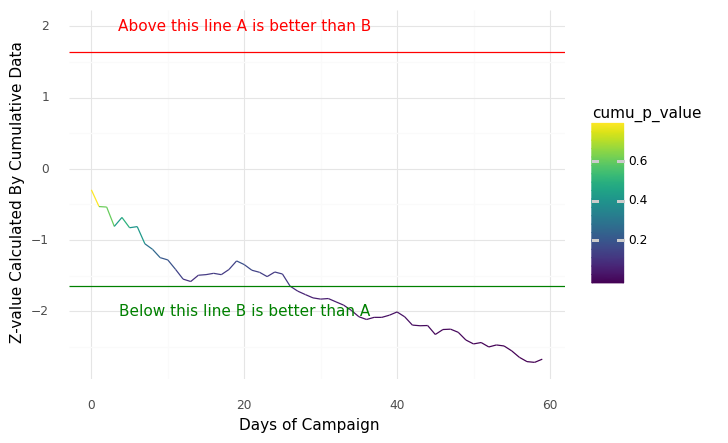

<ggplot: (-9223371879440438475)>

In [19]:
#test
conv_days['cumu_z_value'] = conv_days.apply(lambda row: proportion_test(row['cumu_conv_a'], 
                                                                   row['cumu_conv_b'],row['cumu_click_a'], 
                                                                   row['cumu_click_b'], mode='two_sided')[0],1)
conv_days['cumu_p_value'] = conv_days.apply(lambda row: proportion_test(row['cumu_conv_a'], 
                                                                   row['cumu_conv_b'],row['cumu_click_a'], 
                                                                   row['cumu_click_b'], mode='two_sided')[1],1)

#plot
g = (ggplot(conv_days, aes(x='click_day',y='cumu_z_value',color='cumu_p_value')) + geom_line() + theme_minimal() +
    xlab('Days of Campaign') + ylab('Z-value Calculated By Cumulative Data') +
    geom_hline(yintercept=[sp.stats.norm.ppf(0.95),sp.stats.norm.ppf(0.05)], color=['red','green']) +
    annotate("text", label = "Above this line A is better than B", x = 20, y = 2, color = 'red') +
    annotate("text", label = "Below this line B is better than A", x = 20, y = -2, color = 'green'))
g

In [20]:
def required_samples(mde, p, p_value, mode='one_sided'):
    variance = p*(1-p)
    if mode=='two_sided':
        z = sp.stats.norm.ppf(1-p_value/2)
    elif mode=='one_sided':
        z = sp.stats.norm.ppf(1-p_value)
    else:
        raise ValueError('Available modes are `one_sided` and `two_sided`')
    return 2*variance*(z/mde)**2


def plot_required_samples(mde, p, p_value, mode='one_sided'):
    minimum_samples = required_samples(mde, p, p_value, mode)
    g = (ggplot(conv_days, aes(x='cumu_click_a',y='cumu_z_value',color='cumu_p_value')) + geom_line() + 
        theme_minimal() +
        xlab('Number of Samples per Campaign') + ylab('Z-value Calculated By Cumulative Data') +
        geom_hline(yintercept=[sp.stats.norm.ppf(0.95),sp.stats.norm.ppf(0.05)], color=['red','green']) +
        annotate("text", label = "Above this line A is better than B", x = 30000, y = 2, color = 'red') +
        annotate("text", label = "Below this line B is better than A", x = 30000, y = -2, color = 'green') +
        annotate("text", label = f'Minimum required samples at MDE {mde}={int(minimum_samples)}', x = 30000, y = 0,) +
        geom_vline(xintercept=minimum_samples))
    g.draw()

interact(plot_required_samples, mde = widgets.FloatSlider(min=0.001,max=0.01, value=0.01, step=1e-3,
                                                          readout_format='.5f'),
         p = widgets.FloatSlider(min=0.,max=1, value=0.1, step=1e-3, readout_format='.5f'),
         p_value = widgets.FloatSlider(min=0.01,max=0.1, value=0.05, step=1e-3, readout_format='.5f'),
         mode = widgets.Dropdown(options=['one_sided','two_sided'], value='one_sided')
        )

interactive(children=(FloatSlider(value=0.01, description='mde', max=0.01, min=0.001, readout_format='.5f', st…

<function __main__.plot_required_samples(mde, p, p_value, mode='one_sided')>

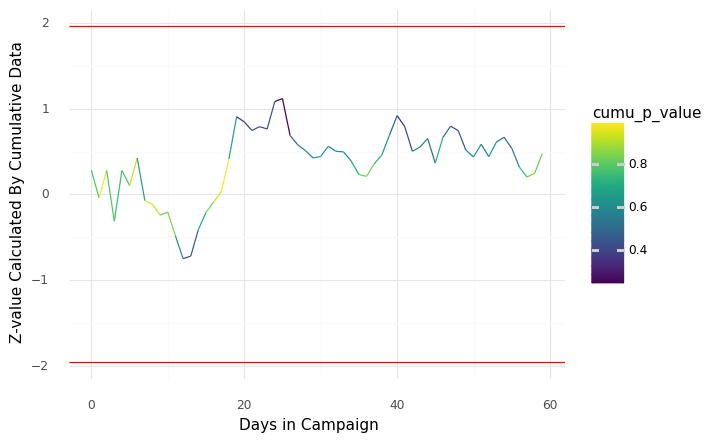

<ggplot: (157412144041)>

In [21]:
conv_days = gen_campaigns(p1 = 0.10,
                          p2 = 0.10,
                          nb_days = 60,
                          scaler=100,
                          seed = 1412) #god-mode 

conv_days['cumu_z_value'] = conv_days.apply(lambda row: proportion_test(row['cumu_conv_a'], 
                                                                   row['cumu_conv_b'],row['cumu_click_a'], 
                                                                   row['cumu_click_b'], mode='two_sided')[0],1)
conv_days['cumu_p_value'] = conv_days.apply(lambda row: proportion_test(row['cumu_conv_a'], 
                                                                   row['cumu_conv_b'],row['cumu_click_a'], 
                                                                   row['cumu_click_b'], mode='two_sided')[1],1)
conv_days['z_value'] = conv_days.apply(lambda row: proportion_test(row['conv_a'], 
                                                                   row['conv_b'],row['click_a'], 
                                                                   row['click_b'], mode='two_sided')[0],1)
conv_days['p_value'] = conv_days.apply(lambda row: proportion_test(row['conv_a'], 
                                                                   row['conv_b'],row['click_a'], 
                                                                   row['click_b'], mode='two_sided')[1],1)
g = (ggplot(conv_days, aes(x='click_day',y='cumu_z_value',color='cumu_p_value')) + geom_line() + theme_minimal() +
    xlab('Days in Campaign') + ylab('Z-value Calculated By Cumulative Data') +
    geom_hline(yintercept=[sp.stats.norm.ppf(0.975),sp.stats.norm.ppf(0.025)], color=['red','red']))
g

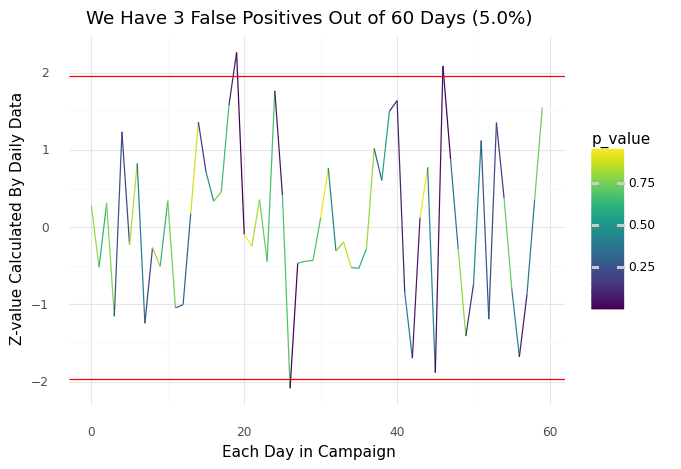

<ggplot: (-9223371879442677567)>

In [22]:
g = (ggplot(conv_days, aes(x='click_day',y='z_value',color='p_value')) + geom_line() + theme_minimal() +
    xlab('Each Day in Campaign') + ylab('Z-value Calculated By Daily Data') +
    geom_hline(yintercept=[sp.stats.norm.ppf(0.975),sp.stats.norm.ppf(0.025)], color=['red','red']) +
    ggtitle(f'We Have {(conv_days.p_value<0.05).sum()} False Positives Out of {conv_days.shape[0]} Days ({100*(conv_days.p_value<0.05).sum()/conv_days.shape[0]}%)'))
g

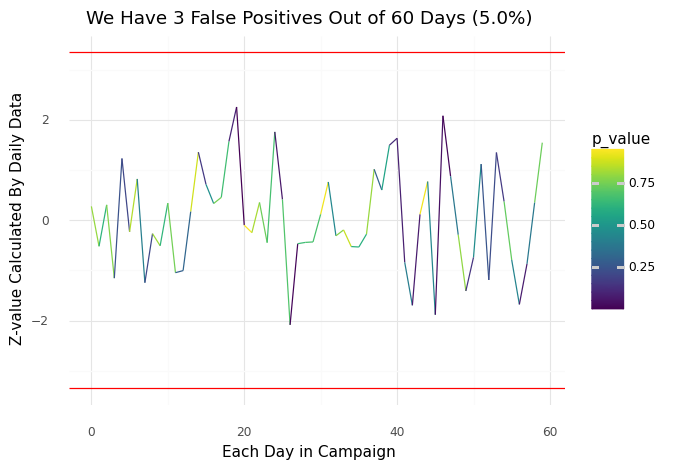

<ggplot: (157411866309)>

In [23]:
g = (ggplot(conv_days, aes(x='click_day',y='z_value',color='p_value')) + geom_line() + theme_minimal() +
    xlab('Each Day in Campaign') + ylab('Z-value Calculated By Daily Data') +
    geom_hline(yintercept=[sp.stats.norm.ppf(1-0.0008/2),sp.stats.norm.ppf(0.0008/2)], color=['red','red']) +
    ggtitle(f'We Have {(conv_days.p_value<0.05).sum()} False Positives Out of {conv_days.shape[0]} Days ({100*(conv_days.p_value<0.05).sum()/conv_days.shape[0]}%)'))
g